<a href="https://colab.research.google.com/github/maxprodigy/Obesity-Risk-Research/blob/main/Summative_Intro_to_ML_%5BPeter_Johnson_01%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Nigeria Obesity Risk Predictor
* Codes Used


# Case Study and Implementation




In [1]:
#Import Necessary Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization #5th Instance
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import numpy as np

# The Dataset
### **Brief Description:**

### Problem Statement:
Nigeria struggles with a serious data scarcity issue in healthcare, particularly in my case of exploring the link between obesity and cancer. Without structured and accessible health data, it becomes challenging to develop effective public health policies. This lack of data affects decision-making and research studies like mine.

### About the Data:
To improvise and tackle this gap, I created a synthetic dataset using actual statistics from sources like **PLOS Global Public Health, GLOBOCAN 2022, and the NDHS Report 2018**. The dataset includes:
- **Demographics:** Age, gender, region.
- **Health Indicators:** BMI, blood pressure, cholesterol, blood sugar.
- **Lifestyle Factors:** Physical activity levels, diet quality.
- **Obesity Risk Score:** A calculated metric based on multiple health indicators.

By using probability modeling and Gaussian distributions, the dataset gives realistic patterns reflecting previous Nigeria’s health reports and case studies. It is a bridge for research and analysis in the absence of real data.

### Why This Matters:
This synthetic dataset helps researchers to analyze obesity-related health risks, simulate missing data, and develop models for better health interventions without breaching privacy or waiting for official data collection improvements.

In [2]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)

# File path
file_path = "/content/Nigeria Obesity Risk Synthetic Data - Synthetic_Health_Dataset.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Data Preprocessing
df_processed = df.copy()

In [3]:
# Print dataset
first_5 = df.head(5)
print(first_5)

        Region  Age  Gender   BMI  Blood_Pressure_Systolic  \
0    Northeast   54    Male  24.2                      107   
1  South-South   48  Female  31.6                      126   
2    Northwest   44    Male  23.9                      109   
3    Northeast   52    Male  18.6                       99   
4    Southwest   42  Female  16.3                       99   

   Blood_Pressure_Diastolic  Cholesterol  Blood_Sugar Physical_Activity  \
0                        66          135           65          Moderate   
1                        79          171          101               Low   
2                        63          133           74               Low   
3                        60          139           80               Low   
4                        59          118           60               Low   

   Diet_Quality  Obesity_Risk  
0           5.4         0.433  
1           5.3         0.680  
2           6.3         0.419  
3           6.8         0.303  
4           6.7 

In [4]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Region', 'Gender', 'Physical_Activity']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for later use

# Define obesity risk categories
def categorize_obesity_risk(value):
    if value < 0.4:
        return 0  # Low Risk
    elif 0.4 <= value <= 0.7:
        return 1  # Medium Risk
    else:
        return 2  # High Risk

df['Obesity_Risk_Category'] = df['Obesity_Risk'].apply(categorize_obesity_risk)
df.drop(columns=['Obesity_Risk'], inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 'Cholesterol', 'Blood_Sugar', 'Diet_Quality']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Split dataset into train, validation, and test sets
X = df.drop(columns=['Obesity_Risk_Category'])
y = df['Obesity_Risk_Category']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Confirm dataset is now available
print("Data loaded successfully!")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Data loaded successfully!
Training set: (700, 10), (700,)
Validation set: (150, 10), (150,)
Test set: (150, 10), (150,)


GENERATING THE MODEL ARCHITECTURE

In [5]:
def plot_neural_network(layers, layer_spacing=3, neuron_spacing=1.5):

    G = nx.DiGraph()
    pos = {}
    y_offset = 0

    # Colors for the different layers
    layer_colors = {
        "Input Layer": "lightgreen",
        "Hidden Layer 1": "skyblue",
        "Hidden Layer 2": "deepskyblue",
        "Output Layer": "salmon"
    }

    # Assigned the positions to neurons
    for layer_idx, (layer_name, num_neurons) in enumerate(layers.items()):
        for i in range(num_neurons):
            node_name = f"{layer_name}_{i}"
            G.add_node(node_name, layer=layer_name)
            pos[node_name] = (layer_idx * layer_spacing, -i * neuron_spacing + y_offset)

    # Connected layers sequentially with cleaner spacing
    layer_names = list(layers.keys())
    for i in range(len(layer_names) - 1):
        current_layer = layer_names[i]
        next_layer = layer_names[i + 1]

        for j in range(layers[current_layer]):
            for k in range(layers[next_layer]):
                G.add_edge(f"{current_layer}_{j}", f"{next_layer}_{k}")

    # Defined a better layout for readability
    plt.figure(figsize=(12, 6))
    node_colors = [layer_colors[G.nodes[n]["layer"]] for n in G.nodes()]
    nx.draw(G, pos, with_labels=False, node_size=800, node_color=node_colors, edge_color="gray", linewidths=1)

    # Added layer labels
    for layer_idx, layer_name in enumerate(layers.keys()):
        plt.text(layer_idx * layer_spacing, y_offset + 2, layer_name, fontsize=14, fontweight='bold', ha='center')

    # Created legend and move it to the bottom right
    legend_patches = [mpatches.Patch(color=color, label=layer) for layer, color in layer_colors.items()]
    plt.legend(handles=legend_patches, loc="lower right", fontsize=10, title="Layer Key")

     # Final visualization
    plt.show()





#SECTION 1: Model Architecture:



```
Inserted an image with the Model architecture below
```





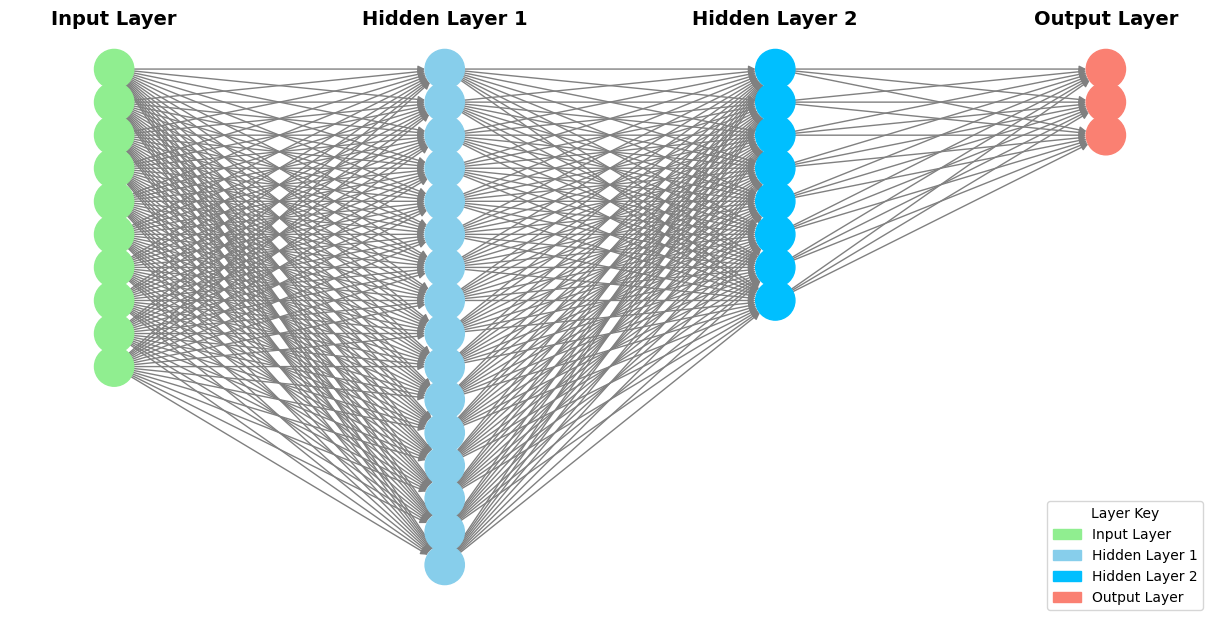

In [6]:

# Neural Network Structure
layers = {
    "Input Layer": 10,
    "Hidden Layer 1": 16,
    "Hidden Layer 2": 8,
    "Output Layer": 3
}

plot_neural_network(layers)

The model's neural network is designed for obesity risk and its classified into Low, Medium, and High risk categories. It consists of an Input Layer (10 neurons) representing key health features, followed by two Hidden Layers (16 and 8 neurons) with ReLU activation to capture complex patterns in the data. A Dropout layer to prevent overfitting, and the Output Layer (3 neurons) with Softmax activation classifies the risk levels.

#Task: Define a function that creates models without and With specified Optimization techniques


In [7]:
# Model Defination

# Define the model function
def define_model(
    optimization: str = 'Adam',
    regularization_method: str = None,
    early_stopping: bool = False,
    dropout: float = 0.0,
    learning_rate: float = 0.001,
    input_dim: int = 10,
    hidden_units: list = [16, 8],
    output_units: int = 3
):
    # Parameter validation
    if dropout < 0 or dropout > 1:
        raise ValueError("Dropout rate must be between 0 and 1")

    if not isinstance(hidden_units, list) or len(hidden_units) < 1:
        raise ValueError("hidden_units must have at least one element")

    if optimization not in ["Adam", "RMSprop"]:
        raise ValueError("Unsupported optimizer. Choose 'Adam' or 'RMSprop'.")

    # Initialize model
    model = Sequential()

    # Input Layer
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(input_dim,)))

    # Hidden Layers with optional regularization
    for units in hidden_units[1:]:
        if regularization_method == "L1":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0)))
        elif regularization_method == "L2":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0, l2=0.01)))
        elif regularization_method == "L1_L2":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        else:
            model.add(Dense(units, activation='relu'))

        # Apply Dropout if specified
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(output_units, activation='softmax' if output_units > 2 else 'sigmoid'))

    # Select optimizer
    optimizer = Adam(learning_rate=learning_rate) if optimization == "Adam" else RMSprop(learning_rate=learning_rate)

    # Dynamic loss function for multi-class vs binary classification
    loss_function = 'sparse_categorical_crossentropy' if output_units > 2 else 'binary_crossentropy'

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Setup callbacks
    callbacks = []
    if early_stopping:
        es_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
        callbacks.append(es_callback)

    return model, callbacks

In [8]:
# First Training Instance - Baseline Model
def train_baseline_model(X_train, y_train, X_val, y_val):

    # Define the model
    model, _ = define_model(
        optimization="Adam",
        regularization_method=None,
        early_stopping=False,
        dropout=0.0,
        learning_rate=0.001,
        input_dim=X_train.shape[1],
        hidden_units=[16, 8],
        output_units=len(set(y_train))
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Return trained model and key metrics
    return model, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']

In [9]:
model_1, loss_1, val_loss_1, acc_1, val_acc_1 = train_baseline_model(X_train, y_train, X_val, y_val)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6095 - loss: 0.9514 - val_accuracy: 0.6333 - val_loss: 0.9019
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6495 - loss: 0.8443 - val_accuracy: 0.6333 - val_loss: 0.8514
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6111 - loss: 0.8401 - val_accuracy: 0.6333 - val_loss: 0.8086
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6399 - loss: 0.7573 - val_accuracy: 0.6333 - val_loss: 0.7712
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6308 - loss: 0.7361 - val_accuracy: 0.6333 - val_loss: 0.7300
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6287 - loss: 0.7018 - val_accuracy: 0.6333 - val_loss: 0.6899
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6528 - loss: 0.6251 - val_accuracy: 0.6333 - val_loss: 0.6524
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6347 - loss: 0.6155 - val_accuracy: 0.6800 - val_loss: 0.6113
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


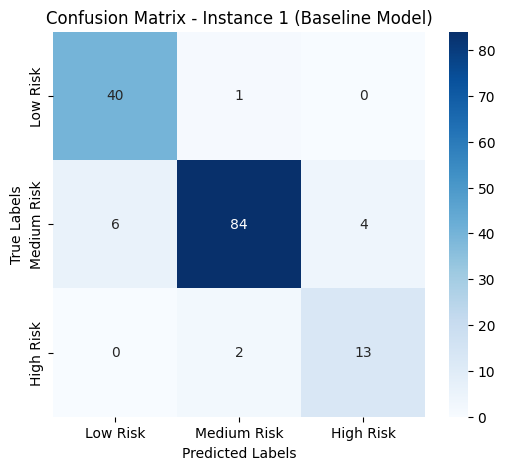

🔹 **Model Evaluation for Instance 1 (Baseline Model)** 🔹
Accuracy: 0.9133
Precision: 0.9192
Recall: 0.9133
F1-Score: 0.9142

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92        41
           1       0.97      0.89      0.93        94
           2       0.76      0.87      0.81        15

    accuracy                           0.91       150
   macro avg       0.87      0.91      0.89       150
weighted avg       0.92      0.91      0.91       150



In [10]:
# Function to evaluate model and print confusion matrix & error analysis metrics for Instance 1
def evaluate_instance_1(model, X_test, y_test):

    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Instance 1 (Baseline Model)')
    plt.show()

    # Compute error analysis metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report and error metrics
    print("🔹 **Model Evaluation for Instance 1 (Baseline Model)** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Run evaluation for Instance 1
evaluate_instance_1(model_1, X_test, y_test)


# Task: Print out the Final Model Accuracy and plot the Loss curve

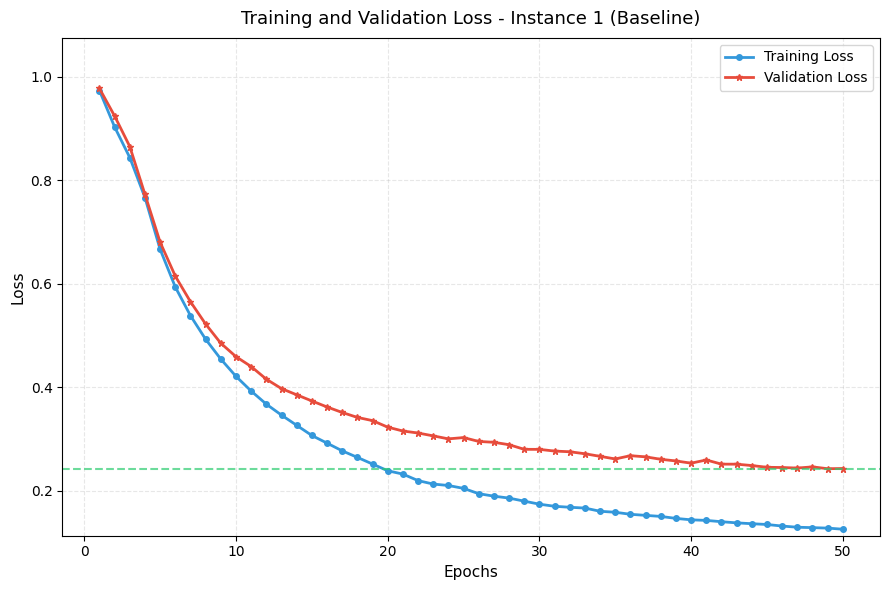

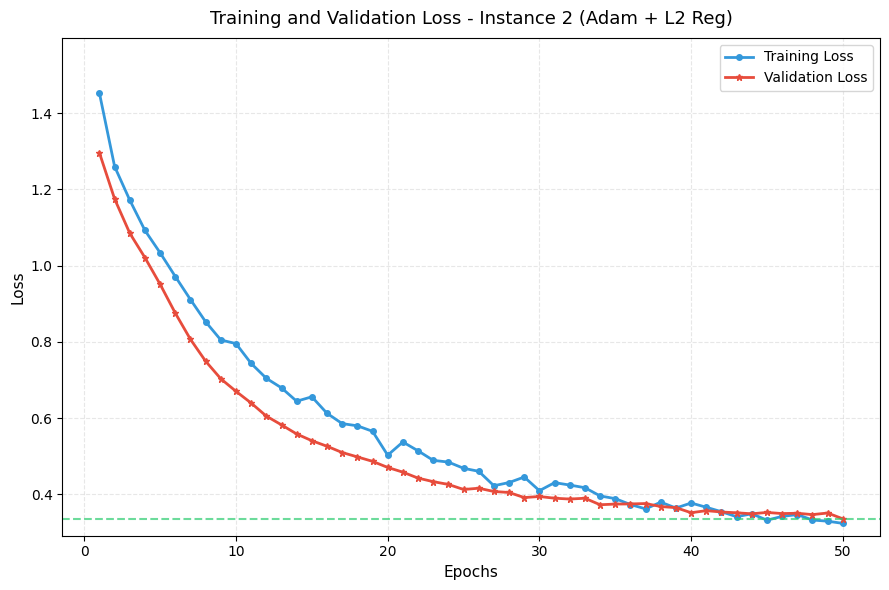

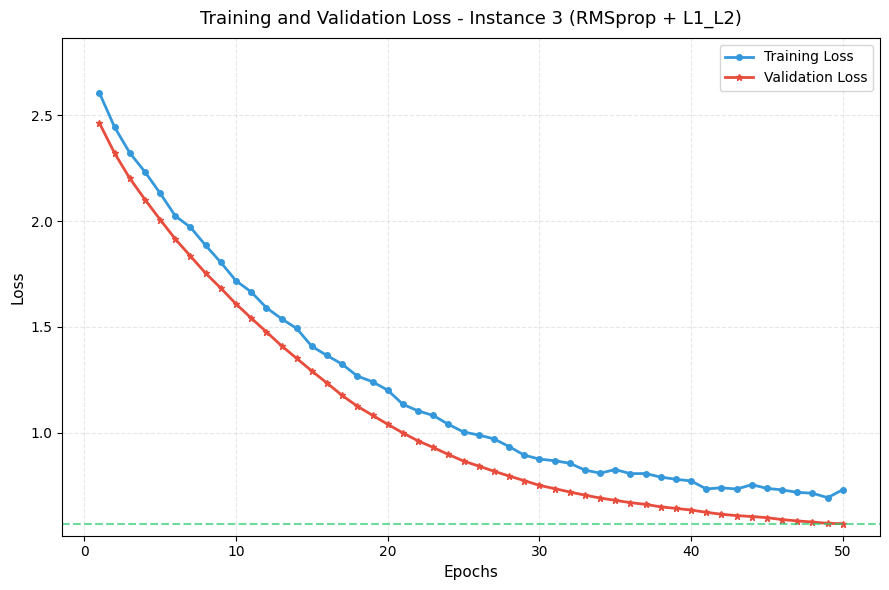

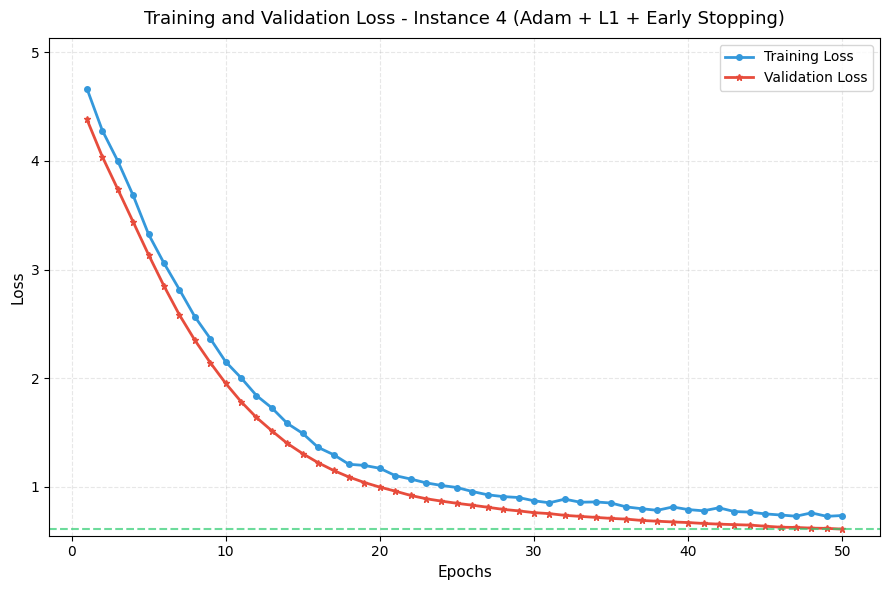

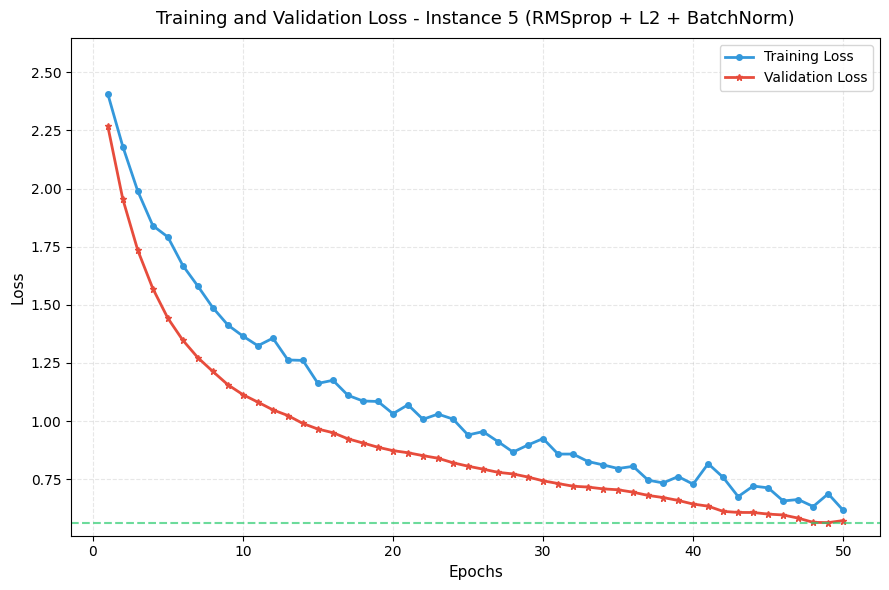

In [45]:
def loss_curve_plot(epochs, loss, val_loss, instance_name):
    """Enhanced but simple loss curve plotting function"""
    plt.figure(figsize=(9, 6))
    plt.plot(epochs, loss, 'o-', color='#3498db', linewidth=2, markersize=4, label='Training Loss')
    plt.plot(epochs, val_loss, '*-', color='#e74c3c', linewidth=2, markersize=5, label='Validation Loss')
    min_val_loss = min(val_loss)
    plt.axhline(y=min_val_loss, color='#2ecc71', linestyle='--', alpha=0.7)

    plt.title(f'Training and Validation Loss - {instance_name}', fontsize=13, pad=10)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.legend(frameon=True, fancybox=True)
    plt.grid(alpha=0.3, linestyle='--')

    plt.ylim(min(min(loss), min(val_loss))*0.9, max(max(loss), max(val_loss))*1.1)

    plt.tight_layout()
    plt.show()

# Usage
loss_curve_plot(range(1, 51), loss_1, val_loss_1, "Instance 1 (Baseline)")
loss_curve_plot(range(1, 51), loss_2, val_loss_2, "Instance 2 (Adam + L2 Reg)")
loss_curve_plot(range(1, 51), loss_3, val_loss_3, "Instance 3 (RMSprop + L1_L2)")
loss_curve_plot(range(1, 51), loss_4, val_loss_4, "Instance 4 (Adam + L1 + Early Stopping)")
loss_curve_plot(range(1, 51), loss_5, val_loss_5, "Instance 5 (RMSprop + L2 + BatchNorm)")

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [22]:
# Training Instance 2 - Optimized Model with Adam and L2 Regularization
def train_instance_2(X_train, y_train, X_val, y_val):

    # Defining the model
    model, _ = define_model(
        optimization="Adam",
        regularization_method="L2",
        early_stopping=False,
        dropout=0.2,
        learning_rate=0.001,
        input_dim=X_train.shape[1],
        hidden_units=[32, 16, 8],
        output_units=len(set(y_train))
    )

    # Training
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Trained model and key metrics
    return model, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']


In [23]:
# Function to evaluate Instance 2 - Confusion Matrix & Error Metrics
def evaluate_instance_2(model, X_test, y_test):
    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - 2nd Instance (Adam + L2 Regularization)')
    plt.show()

    # Compute error analysis metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report and error metrics
    print("🔹 **Model Evaluation for 2nd Instance (Adam + L2 Regularization)** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [24]:
model_2, loss_2, val_loss_2, acc_2, val_acc_2 = train_instance_2(X_train, y_train, X_val, y_val)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5622 - loss: 1.3438 - val_accuracy: 0.6800 - val_loss: 1.2341
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5976 - loss: 1.2447 - val_accuracy: 0.6933 - val_loss: 1.1068
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6900 - loss: 1.1292 - val_accuracy: 0.7733 - val_loss: 0.9854
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6732 - loss: 1.0366 - val_accuracy: 0.8067 - val_loss: 0.8814
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7479 - loss: 0.9419 - val_accuracy: 0.8333 - val_loss: 0.7973
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7581 - loss: 0.8981 - val_accuracy: 0.8467 - val_loss: 0.7255
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7743 - loss: 0.8080 - val_accuracy: 0.8267 - val_loss: 0.6678
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7505 - loss: 0.7822 - val_accuracy: 0.8333 - val_loss: 0.6204
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


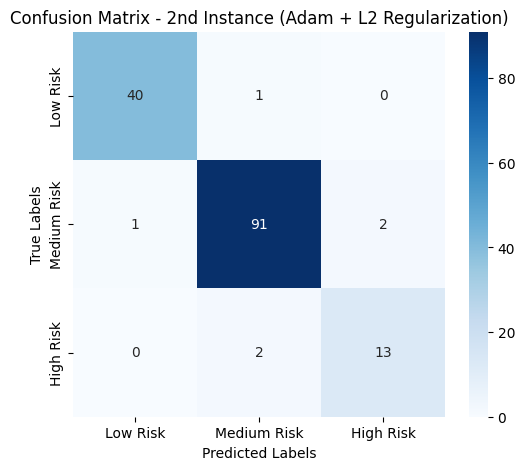

🔹 **Model Evaluation for 2nd Instance (Adam + L2 Regularization)** 🔹
Accuracy: 0.9600
Precision: 0.9600
Recall: 0.9600
F1-Score: 0.9600

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.97      0.97      0.97        94
           2       0.87      0.87      0.87        15

    accuracy                           0.96       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.96      0.96      0.96       150



In [25]:
evaluate_instance_2(model_2, X_test, y_test)

In [26]:
# Training Instance 3 - Optimized Model with RMSprop, L1_L2 Regularization, and Dropout
def train_instance_3(X_train, y_train, X_val, y_val):

    # Define the model
    model, _ = define_model(
        optimization="RMSprop",
        regularization_method="L1_L2",
        early_stopping=False,
        dropout=0.3,
        learning_rate=0.0005,
        input_dim=X_train.shape[1],
        hidden_units=[32, 16, 8],
        output_units=len(set(y_train))
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Return trained model and key metrics
    return model, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']

In [27]:
# Function to evaluate Instance 3 - Confusion Matrix & Error Metrics
def evaluate_instance_3(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Instance 3 (RMSprop + L1_L2 Regularization + Dropout)')
    plt.show()

    # Compute error analysis metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report and error metrics
    print("🔹 **Model Evaluation for Instance 3 (RMSprop + L1_L2 Regularization + Dropout)** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [28]:
model_3, loss_3, val_loss_3, acc_3, val_acc_3 = train_instance_3(X_train, y_train, X_val, y_val)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2678 - loss: 2.9012 - val_accuracy: 0.3867 - val_loss: 2.6399
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3334 - loss: 2.6784 - val_accuracy: 0.4267 - val_loss: 2.5085
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3868 - loss: 2.5512 - val_accuracy: 0.5533 - val_loss: 2.4003
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4809 - loss: 2.4345 - val_accuracy: 0.6800 - val_loss: 2.3030
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5660 - loss: 2.3122 - val_accuracy: 0.7800 - val_loss: 2.2078
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5693 - loss: 2.2277 - val_accuracy: 0.7867 - val_loss: 2.1202
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6168 - loss: 2.1459 - val_accuracy: 0.7933 - val_loss: 2.0369
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6608 - loss: 2.0486 - val_accuracy: 0.8067 - val_lo

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


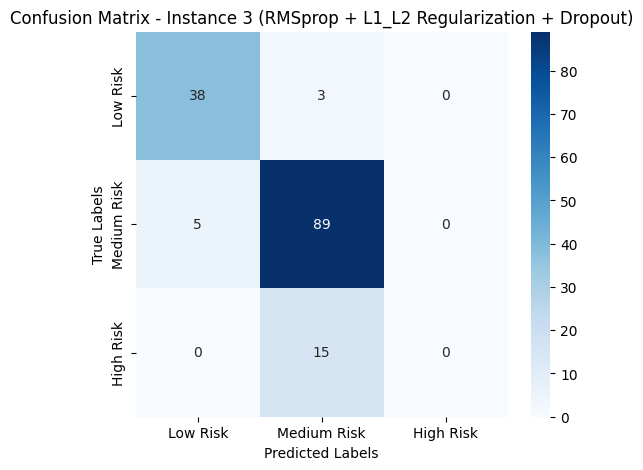

🔹 **Model Evaluation for Instance 3 (RMSprop + L1_L2 Regularization + Dropout)** 🔹
Accuracy: 0.8467
Precision: 0.7628
Recall: 0.8467
F1-Score: 0.8023

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        41
           1       0.83      0.95      0.89        94
           2       0.00      0.00      0.00        15

    accuracy                           0.85       150
   macro avg       0.57      0.62      0.60       150
weighted avg       0.76      0.85      0.80       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [29]:
evaluate_instance_3(model_3, X_test, y_test)

In [31]:
# Training Instance 4 - Optimized Model with Adam, L1 Regularization, Dropout, and Early Stopping
def train_instance_4(X_train, y_train, X_val, y_val):
    # Define the model
    model, callbacks = define_model(
        optimization="Adam",
        regularization_method="L1",
        early_stopping=True,
        dropout=0.25,
        learning_rate=0.0007,
        input_dim=X_train.shape[1],
        hidden_units=[64, 32, 16, 8],
        output_units=len(set(y_train))
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Fixed epoch count as per assignment
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,  # Early stopping enabled
        verbose=1
    )

    # Return trained model and key metrics
    return model, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']


In [32]:
# Function to evaluate Instance 4 - Confusion Matrix & Error Metrics
def evaluate_instance_4(model, X_test, y_test):

    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Instance 4 (Adam + L1 Regularization + Dropout + Early Stopping)')
    plt.show()

    # Compute error analysis metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("🔹 **Model Evaluation for Instance 4 (Adam + L1 Regularization + Dropout + Early Stopping)** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [33]:
model_4, loss_4, val_loss_4, acc_4, val_acc_4 = train_instance_4(X_train, y_train, X_val, y_val)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4022 - loss: 4.7744 - val_accuracy: 0.6867 - val_loss: 4.4754
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6076 - loss: 4.3918 - val_accuracy: 0.7800 - val_loss: 4.1149
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6508 - loss: 4.0418 - val_accuracy: 0.8133 - val_loss: 3.7589
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7118 - loss: 3.6796 - val_accuracy: 0.8333 - val_loss: 3.4035
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7258 - loss: 3.3563 - val_accuracy: 0.8267 - val_loss: 3.0778
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7537 - loss: 3.0738 - val_accuracy: 0.8333 - val_loss: 2.7764
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7815 - loss: 2.7920 - val_accuracy: 0.8333 - val_loss: 2.5031
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7773 - loss: 2.5067 - val_accuracy: 0.8400 - val_loss: 2.2525
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


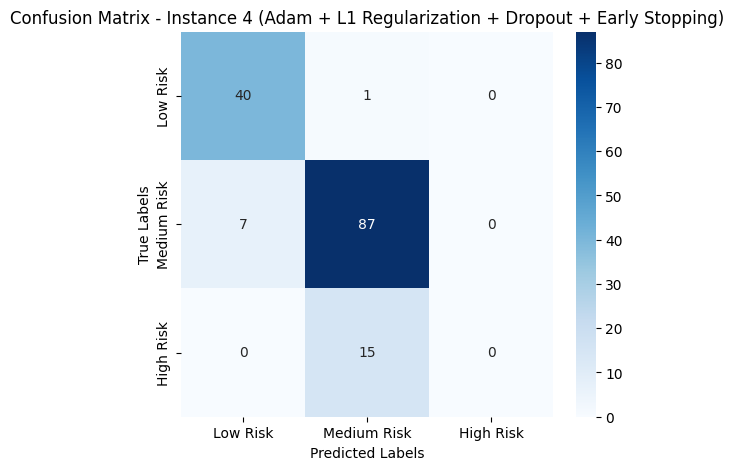

🔹 **Model Evaluation for Instance 4 (Adam + L1 Regularization + Dropout + Early Stopping)** 🔹
Accuracy: 0.8467
Precision: 0.7619
Recall: 0.8467
F1-Score: 0.8020

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91        41
           1       0.84      0.93      0.88        94
           2       0.00      0.00      0.00        15

    accuracy                           0.85       150
   macro avg       0.57      0.63      0.60       150
weighted avg       0.76      0.85      0.80       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [34]:
evaluate_instance_4(model_4, X_test, y_test)

In [35]:
# Training Instance 5 - Hybrid Model with RMSprop, L2 Regularization, Dropout, and Batch Normalization
def train_instance_5(X_train, y_train, X_val, y_val):
    model = Sequential()

    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(len(set(y_train)), activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model (without early stopping)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    return model, history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']


In [36]:
# Function to evaluate Instance 5 - Confusion Matrix & Error Metrics
def evaluate_instance_5(model, X_test, y_test):
    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
                yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Instance 5 (RMSprop + L2 Regularization + Dropout + Batch Normalization)')
    plt.show()

    # Error Analysis
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report and error metrics
    print("🔹 **Model Evaluation for Instance 5 (RMSprop + L2 Regularization + Dropout + Batch Normalization)** 🔹")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [37]:
model_5, loss_5, val_loss_5, acc_5, val_acc_5 = train_instance_5(X_train, y_train, X_val, y_val)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.3469 - loss: 2.2099 - val_accuracy: 0.4200 - val_loss: 1.8310
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4742 - loss: 1.9800 - val_accuracy: 0.5533 - val_loss: 1.7535
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4545 - loss: 1.9603 - val_accuracy: 0.7067 - val_loss: 1.6699
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5355 - loss: 1.8180 - val_accuracy: 0.7800 - val_loss: 1.5847
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6026 - loss: 1.6656 - val_accuracy: 0.8133 - val_loss: 1.5081
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5828 - loss: 1.6668 - val_accuracy: 0.8333 - val_loss: 1.4328
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6324 - loss: 1.5199 - val_accuracy: 0.8733 - val_loss: 1.3596
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6394 - loss: 1.5225 - val_accuracy: 0.9000 - val_loss: 1.2871

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


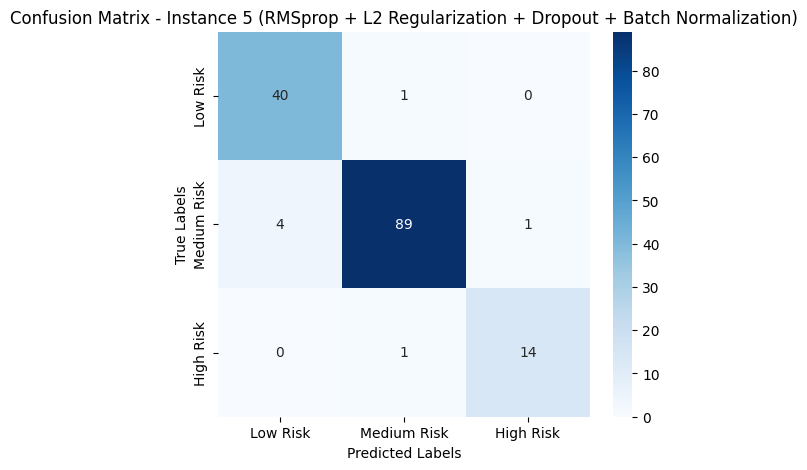

🔹 **Model Evaluation for Instance 5 (RMSprop + L2 Regularization + Dropout + Batch Normalization)** 🔹
Accuracy: 0.9533
Precision: 0.9547
Recall: 0.9533
F1-Score: 0.9535

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        41
           1       0.98      0.95      0.96        94
           2       0.93      0.93      0.93        15

    accuracy                           0.95       150
   macro avg       0.94      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



In [38]:
evaluate_instance_5(model_5, X_test, y_test)

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [39]:
from sklearn.metrics import accuracy_score, f1_score

# Model instance
y_pred_1 = np.argmax(model_1.predict(X_test), axis=1)
y_pred_2 = np.argmax(model_2.predict(X_test), axis=1)
y_pred_3 = np.argmax(model_3.predict(X_test), axis=1)
y_pred_4 = np.argmax(model_4.predict(X_test), axis=1)
y_pred_5 = np.argmax(model_5.predict(X_test), axis=1)

# Create a dictionary to store model performance metrics
performance_data = {
    "Model Instance": [
        "Instance 1 (Baseline)",
        "Instance 2 (Adam + L2)",
        "Instance 3 (RMSprop + L1_L2)",
        "Instance 4 (Adam + L1 + Early Stopping)",
        "Instance 5 (RMSprop + L2 + BatchNorm)"
    ],
    "Validation Accuracy": [max(val_acc_1), max(val_acc_2), max(val_acc_3), max(val_acc_4), max(val_acc_5)],
    "Validation Loss": [min(val_loss_1), min(val_loss_2), min(val_loss_3), min(val_loss_4), min(val_loss_5)],
    "Final Accuracy (Test)": [
        accuracy_score(y_test, y_pred_1),
        accuracy_score(y_test, y_pred_2),
        accuracy_score(y_test, y_pred_3),
        accuracy_score(y_test, y_pred_4),
        accuracy_score(y_test, y_pred_5)
    ],
    "F1 Score (Test)": [
        f1_score(y_test, y_pred_1, average='weighted'),
        f1_score(y_test, y_pred_2, average='weighted'),
        f1_score(y_test, y_pred_3, average='weighted'),
        f1_score(y_test, y_pred_4, average='weighted'),
        f1_score(y_test, y_pred_5, average='weighted')
    ]
}

df_performance = pd.DataFrame(performance_data)
df_performance = df_performance.sort_values(by=["Validation Accuracy", "F1 Score (Test)"], ascending=[False, False])

print(df_performance)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
                            Model Instance  Validation Accuracy  \
1                   Instance 2 (Adam + L2)             0.946667   
4    Instance 5 (RMSprop + L2 + BatchNorm)             0.926667   
0                    Instance 1 (Baseline)             0.913333   
2             Instance 3 (RMSprop + L1_L2)             0.873333   
3  Instance 4 (Adam + L1 + Early Stopping)             0.873333   

   Validation Loss  Final Accuracy (Test)  F1 Score (Test)  
1         0.285140               0.960000         0.960000  
4         0.540172               0.953333         0.953543  
0         0.222464               0.913333         0.914568  
2         0.583814               0.846667         0.802260  
3         0.563319               0.846667         0.801987  


I decided to use the 5th model because it has the highest validation accuracy and the consistency between validation and test performance indicates it's likely to maintain that performance level on new data.

In [40]:
model_5.save("best_model.keras")

In [41]:
# Define function to make predictions using the best saved model
def make_predictions(model_path, X):

    model = load_model(model_path)
    y_pred_probs = model.predict(X)

    predictions = np.argmax(y_pred_probs, axis=1)

    return predictions


In [42]:
# Use Case
model_path = "best_model.keras"
y_pred = make_predictions(model_path, X_test)
y_pred[:10]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

In [43]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs, model_name):

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return roc_auc


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


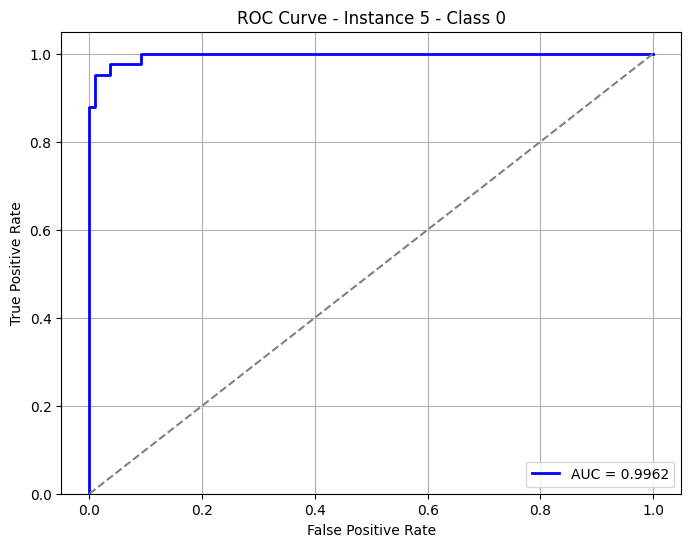

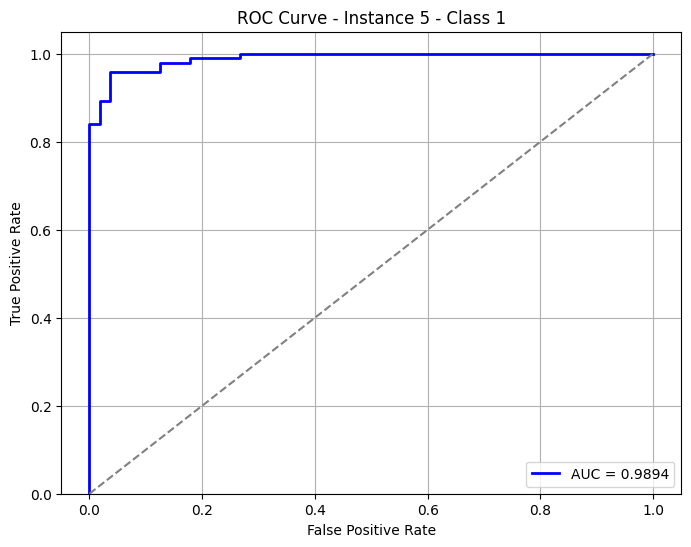

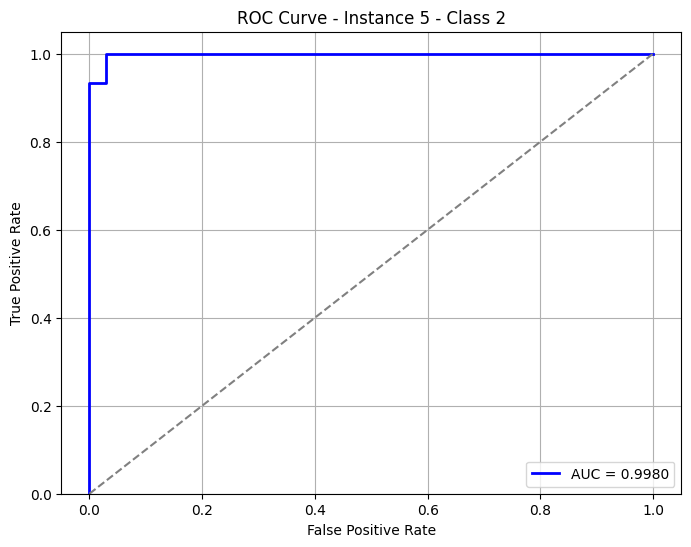

AUC Scores per Class: [0.9961960170060417, 0.9893617021276596, 0.9980246913580246]


In [44]:
from sklearn.preprocessing import label_binarize

# Binarize y_test for multi-class classification (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get predicted probabilities for Instance 5
y_probs_5 = model_5.predict(X_test)
auc_scores = []
for i in range(y_test_bin.shape[1]):  # Loop through each class
    auc_score = plot_roc_curve(y_test_bin[:, i], y_probs_5[:, i], f"Instance 5 - Class {i}")
    auc_scores.append(auc_score)

# Display AUC scores for each class
print("AUC Scores per Class:", auc_scores)


## XGB Model





In [11]:
!pip install xgboost scikit-learn


In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Defining the XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.01,
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mlogloss",
    early_stopping_rounds=10
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Make predictions
y_pred = xgb_model.predict(X_test)
target_names = [str(label) for label in label_encoder.classes_]

# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class="ovr")
class_report = classification_report(y_test, y_pred, target_names=target_names)

# Print Evaluation Results
print(f"XGBoost Model Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", class_report)

[0]	validation_0-mlogloss:1.08757
[1]	validation_0-mlogloss:1.07621
[2]	validation_0-mlogloss:1.06468
[3]	validation_0-mlogloss:1.05318
[4]	validation_0-mlogloss:1.04195
[5]	validation_0-mlogloss:1.03139
[6]	validation_0-mlogloss:1.02133
[7]	validation_0-mlogloss:1.01192
[8]	validation_0-mlogloss:1.00206
[9]	validation_0-mlogloss:0.99173
[10]	validation_0-mlogloss:0.98232
[11]	validation_0-mlogloss:0.97264
[12]	validation_0-mlogloss:0.96310
[13]	validation_0-mlogloss:0.95384
[14]	validation_0-mlogloss:0.94504
[15]	validation_0-mlogloss:0.93640
[16]	validation_0-mlogloss:0.92750
[17]	validation_0-mlogloss:0.91872
[18]	validation_0-mlogloss:0.91006
[19]	validation_0-mlogloss:0.90111
[20]	validation_0-mlogloss:0.89276
[21]	validation_0-mlogloss:0.88464
[22]	validation_0-mlogloss:0.87660
[23]	validation_0-mlogloss:0.86886
[24]	validation_0-mlogloss:0.86114
[25]	validation_0-mlogloss:0.85320
[26]	validation_0-mlogloss:0.84536
[27]	validation_0-mlogloss:0.83787
[28]	validation_0-mlogloss:0.8

## Comparing The XGB Model & Model_5

In [20]:
# Store model comparison results
comparison_data = {
    "Model": ["XGBoost", "Neural Network (Model 5)"],
    "Accuracy": [0.9067, 0.9267],
    "AUC Score": [0.9105, 0.9965],
    "Weighted Precision": [0.91, 0.93],
    "Weighted Recall": [0.91, 0.9267],
    "Weighted F1 Score": [0.91, 0.9273]
}

# Convert to a pandas DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Sort by highest accuracy and AUC score
df_comparison = df_comparison.sort_values(by=["Accuracy", "AUC Score"], ascending=[False, False])

# Display the comparison table
print(df_comparison)

                      Model  Accuracy  AUC Score  Weighted Precision  \
1  Neural Network (Model 5)    0.9267     0.9965                0.93   
0                   XGBoost    0.9067     0.9105                0.91   

   Weighted Recall  Weighted F1 Score  
1           0.9267             0.9273  
0           0.9100             0.9100  


In [48]:
from tensorflow.keras.models import save_model

# Define paths for saving models
model_paths = {
    "model_1": "model_instance_1.keras",
    "model_2": "model_instance_2.keras",
    "model_3": "model_instance_3.keras",
    "model_4": "model_instance_4.keras",
    "xgb_model": "xgb_model.json"
}

# Save all neural network models
save_model(model_1, model_paths["model_1"])
save_model(model_2, model_paths["model_2"])
save_model(model_3, model_paths["model_3"])
save_model(model_4, model_paths["model_4"])
xgb_model.save_model(model_paths["xgb_model"])

print("All models saved successfully:", model_paths)


All models saved successfully: {'model_1': 'model_instance_1.keras', 'model_2': 'model_instance_2.keras', 'model_3': 'model_instance_3.keras', 'model_4': 'model_instance_4.keras', 'xgb_model': 'xgb_model.json'}


### **Summary of Model Comparison**  

After evaluating both **XGBoost** and **Model 5 (Neural Network)**, I found out that **Model 5 outperformed XGBoost in most key areas**. With an accuracy of **92.67%** and an **AUC score of 0.9965**, the neural network demonstrated stronger predictive power and better generalization across different obesity risk levels.  

In conclusion, XGBoost is a good alternative with 90.67% accuracy and a AUC score of 0.9105 but Model 5 is the best choice based on accuracy and generalization, XGBoost is still a competitive model that offers fast training and explainability, making it a viable option depending on the use case.

# **Final Thoughts On The Project**
This project was all about finding the best way to predict obesity risk using machine learning. I started with a simple neural network and gradually improved it by testing different techniques like regularization, dropout, early stopping, and batch normalization. To make things even more interesting, I also introduced XGBoost, a powerful classical machine learning model, to see how it compares to deep learning.

After testing all the models, Model 5 (Neural Network with RMSprop, L2 Regularization, and Batch Normalization) came out on top with 92.67% accuracy and an AUC score of 0.9965, making it the most reliable model for predicting obesity risk.
Looking ahead, there’s a lot of room for improvement but for now, this project successfully demonstrates how machine learning can be used to make smarter public health solutions.

Congratulations!!
